In [ ]:
!pip install spmf

In [2]:
!pip install --quiet git+https://github.com/EgorDudyrev/paspailleur.git
import caspailleur as csp
from paspailleur import pattern_structures as PS

In [3]:
from importlib import reload

In [29]:
from script import clustering as clib, visual_lib as vlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
from functools import reduce
from bitarray import frozenbitarray

# Test example of AprioriRare via SPMF

rare_itemsets_input.txt is taken from https://www.philippe-fournier-viger.com/spmf/AprioriInverse.php example

In [6]:
!java -jar ../script/spmf.jar run AprioriRare rare_itemsets_input.basenum rare_output.txt 50%

>/Users/egordudyrev/Documents/1. Projects/StablePatternClustering project/Paper_StablePatternClustering/script/spmf.jar
=============  APRIORI-RARE - STATS =============
 Candidates count : 14
 The algorithm stopped at size 4, because there is no candidate
 Minimal rare itemsets count : 3
 Maximum memory usage : 10.457344055175781 mb
 Total time ~ 6 ms


In [7]:
!rm rare_output.txt rare_output.pkl rare_output.csv
from spmf import Spmf

spmf = Spmf(
    "AprioriRare", input_filename="rare_itemsets_input.basenum",
    output_filename="rare_output.txt", arguments=['50%'],
    spmf_bin_location_dir='../script/'
)
spmf.run()

#print(spmf.to_pandas_dataframe(pickle=True))
#spmf.to_csv("rare_output.csv")

rm: rare_output.pkl: No such file or directory
rm: rare_output.csv: No such file or directory
>/Users/egordudyrev/Documents/1. Projects/StablePatternClustering project/Paper_StablePatternClustering/script/spmf.jar
=============  APRIORI-RARE - STATS =============
 Candidates count : 14
 The algorithm stopped at size 4, because there is no candidate
 Minimal rare itemsets count : 3
 Maximum memory usage : 10.457344055175781 mb
 Total time ~ 7 ms



In [8]:
!cat rare_output.txt

4 #SUP: 1
1 2 3  #SUP: 2
1 3 5  #SUP: 2


In [9]:
with open('rare_itemsets_input.basenum', 'r') as file:
    itemsets = [set(map(int,line.strip().split(' '))) for line in file.readlines()]
attr_extents = csp.io.transpose_context(csp.to_bitarrays(itemsets)[0])

In [10]:
clib = reload(clib)

print(list(clib.mine_rare_itemsets(attr_extents, int(len(itemsets)/2))))

[(3,)]


In [11]:
%timeit list(clib.mine_rare_itemsets(attr_extents, 2))

21.2 µs ± 53.9 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# Test examples on Circles data

In [6]:
from sklearn import datasets

n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
X, y = noisy_circles

In [7]:
linscale_x = np.linspace(X[:,0].min(), X[:,0].max(), 11)
linscale_y = np.linspace(X[:,1].min(), X[:,1].max(), 11)
ps = PS.CartesianPS([PS.IntervalPS(values=linscale_x), PS.IntervalPS(values=linscale_y)])

In [8]:
min_support = 0.01
max_support = 0.8
min_delta_stability = 0.01

In [9]:
data = list(ps.preprocess_data(X))
attributes, attr_extents = zip(*ps.iter_attributes(data, min_support=min_support))
print(len(attributes))

38


In [10]:
%%time
stable_extents = csp.mine_equivalence_classes.list_stable_extents_via_gsofia(
    attr_extents,
    n_objects=len(data), min_delta_stability=min_delta_stability, min_supp=min_support,
    use_tqdm=True, n_attributes=len(attributes)
)
stable_extents = sorted(stable_extents, key=lambda ext: ext.count(), reverse=True)
print(f"n extents", len(stable_extents))

  0%|          | 0/38 [00:00<?, ?it/s]

n extents 1729
CPU times: user 56.6 ms, sys: 20.5 ms, total: 77.1 ms
Wall time: 74.5 ms


In [11]:
from bitarray.util import count_and, count_or

jaccard_thold = 0.1
sparse_extents = []
for i, extent in enumerate(stable_extents):
    not_like_others = all(count_and(extent, other)/count_or(extent, other) <= jaccard_thold
                          for other in sparse_extents)
    if not_like_others:
        sparse_extents.append(extent)
print(len(stable_extents), len(sparse_extents))

1729 16


In [12]:
anticoncepts_bas = [~ba for ba in csp.io.transpose_context(sparse_extents)]
anticoncepts_itemsets = [{i+1 for i in iset} for iset in csp.to_itemsets(anticoncepts_bas)[0]]

In [13]:
with open('anticoncepts_circles.basenum', 'w') as file:
    txt = '\n'.join([
        ' '.join(map(str, itemset)) if itemset else ''
        for itemset in anticoncepts_itemsets
    ])
    file.write(txt)

In [14]:
%%time
from spmf import Spmf

spmf = Spmf(
    "AprioriRare", input_filename="anticoncepts_circles.basenum",
    output_filename="clusterings_circles.txt", arguments=['80%'],
    spmf_bin_location_dir='../script/'
)
spmf.run()

#print(spmf.to_pandas_dataframe(pickle=True))
#spmf.to_csv("clusterings_circles.csv")

>/Users/egordudyrev/Documents/1. Projects/StablePatternClustering project/Paper_StablePatternClustering/script/spmf.jar
=============  APRIORI-RARE - STATS =============
 Candidates count : 943
 The algorithm stopped at size 7, because there is no candidate
 Minimal rare itemsets count : 328
 Maximum memory usage : 10.937385559082031 mb
 Total time ~ 37 ms

CPU times: user 2.6 ms, sys: 10.3 ms, total: 12.9 ms
Wall time: 331 ms


In [15]:
with open('clusterings_circles.txt', 'r') as file:
    lines = list(map(str.strip, file.readlines()))
    clusterings, supports = zip(*map(lambda x: str.split(x, '#SUP:'), lines))
    #clusterings = [frozenset(map(int, line.strip().split(' '))) for line in clusterings]
    clusterings = [frozenset([int(x)-1 for x in line.strip().split(' ')]) for line in clusterings]
    supports = [int(line.strip()) for line in supports]
print(len(clusterings), len(supports))

328 328


In [16]:
anticoncepts_extents = [~ext for ext in sparse_extents]
print(len(anticoncepts_extents))

16


In [17]:
clib = reload(clib)

In [18]:
%%time
rare_itemsets_mine1 = list(map(frozenset, clib.mine_rare_itemsets(anticoncepts_extents, 400, max_length=10)))

CPU times: user 41 ms, sys: 6.08 ms, total: 47.1 ms
Wall time: 46.8 ms


In [19]:
clib = reload(clib)

In [20]:
%%time
rare_itemsets_mine = list(map(frozenset, clib.mine_clusterings(sparse_extents, 100, max_length=10)))

CPU times: user 3.77 ms, sys: 110 µs, total: 3.88 ms
Wall time: 3.89 ms


In [21]:
clib = reload(clib)  # with no min_added_coverage
%timeit list(map(frozenset, clib.mine_clusterings(sparse_extents, 100, max_length=10)))

1.22 ms ± 6.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [22]:
clib = reload(clib)  # with min_added_coverage
%timeit list(map(frozenset, clib.mine_clusterings(sparse_extents, 100, max_length=10, min_added_coverage=0)))
%timeit list(map(frozenset, clib.mine_clusterings(sparse_extents, 100, max_length=10, min_added_coverage=25)))
%timeit list(map(frozenset, clib.mine_clusterings(sparse_extents, 100, max_length=10, min_added_coverage=50)))
%timeit list(map(frozenset, clib.mine_clusterings(sparse_extents, 100, max_length=10, min_added_coverage=100)))

1.26 ms ± 11.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
401 µs ± 2.79 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
139 µs ± 688 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
12.8 µs ± 25.1 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [23]:
print(len(list(map(frozenset, clib.mine_clusterings(sparse_extents, 100, max_length=10, min_added_coverage=0)))))
print(len(list(map(frozenset, clib.mine_clusterings(sparse_extents, 100, max_length=10, min_added_coverage=25)))))
print(len(list(map(frozenset, clib.mine_clusterings(sparse_extents, 100, max_length=10, min_added_coverage=50)))))
print(len(list(map(frozenset, clib.mine_clusterings(sparse_extents, 100, max_length=10, min_added_coverage=100)))))

329
121
8
1


# Run on "real" data

In [24]:
from bitarray.util import count_and, count_or

jaccard_thold = 0.9
sparse_extents = []
for i, extent in enumerate(stable_extents):
    not_like_others = all(count_and(extent, other)/count_or(extent, other) <= jaccard_thold
                          for other in sparse_extents)
    if not_like_others:
        sparse_extents.append(extent)
print(len(stable_extents), len(sparse_extents))

1729 1274


In [25]:
%%time
clusterings = list(clib.mine_clusterings(sparse_extents, min_support=450, max_length=5, min_added_coverage=100))
print(len(clusterings))

9754
CPU times: user 1min 22s, sys: 476 ms, total: 1min 22s
Wall time: 1min 22s


In [26]:
print(max(map(len, clusterings)))

4


In [27]:
concepts_dict = clib.mine_clusters_info(sparse_extents, attr_extents, ps, data, 0, 1)

In [30]:
weight_params = dict(
    overlap_weight=0.2,
    n_concepts_weight=0.1,
    imbalance_weight=0.1,
    stability_weight=0.2,
    complexity_weight=0.1,
    n_concepts_max=5,
)
clusterings_dict = {
    idxs: clib.clustering_reward2(idxs, concepts_info=concepts_dict, **weight_params)[1]
    for idxs in clusterings
}
clusterings_df = pd.DataFrame(clusterings_dict).T
clusterings_df.index = clusterings

In [31]:
if 'reward' in clusterings_df.columns:
    clusterings_df = clusterings_df.drop(columns='reward')

signs = np.array([1 if f in {'coverage', 'stability'} else -1 for f in clusterings_df])
weights = np.array([1 if f == 'coverage' else weight_params[f"{f}_weight"] for f in clusterings_df])

clusterings_df['reward'] = (clusterings_df*weights*signs).sum(1)

In [32]:
clusterings_df = clusterings_df.sort_values('reward', ascending=False)

In [33]:
clusterings_df.head()

,coverage,overlap,n_concepts,imbalance,stability,complexity,reward
"(0,)",1.0,0.000,0.2,0.000000,0.555556,0.0,1.091111
"(95, 121)",1.0,0.000,0.4,0.033941,0.444444,0.5,0.995495
"(50, 121)",1.0,0.100,0.4,0.104652,0.522222,0.5,0.983979
"(50, 59)",1.0,0.234,0.4,0.009899,0.588889,0.5,0.979988
"(59, 95)",1.0,0.134,0.4,0.060811,0.511111,0.5,0.979341


In [34]:
best_clustering = clusterings_df.index[2]
#best_clustering = clusterings_df.sort_values('overlap').index[0]
concepts_df = pd.DataFrame(concepts_dict)

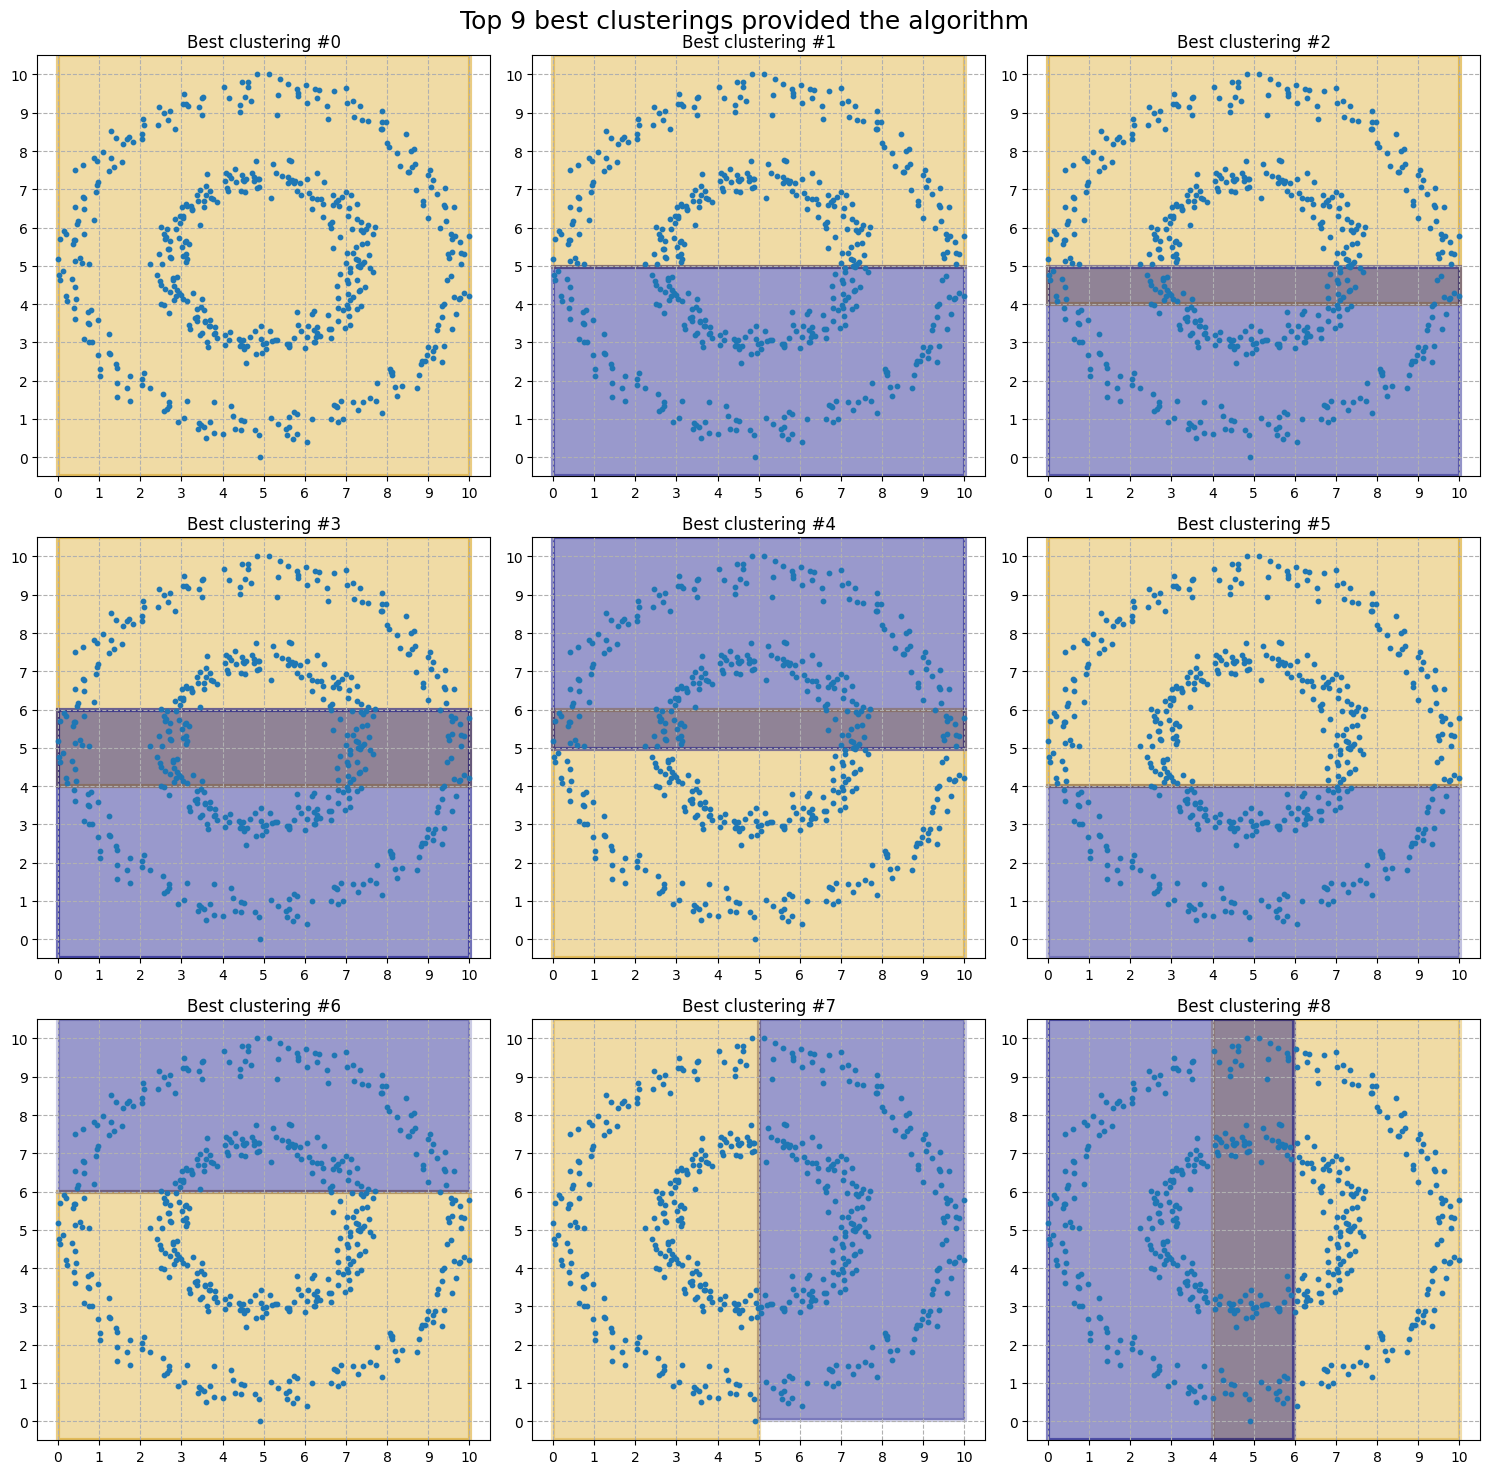

In [35]:
best_clustering = clusterings_df.index[9]

fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i, (ax, best_clustering) in enumerate(zip(axs.flatten(), clusterings_df.index)):
    vlib.init_axis(ax, f"Best clustering #{i}", 
                   linscale_x, linscale_y, range(len(linscale_x)), range(len(linscale_y)), 
                   grid_params=dict(zorder=0, linestyle='--'))
    
    ax.scatter(X[:,0], X[:,1], zorder=2, s=10)
    vlib.draw_clustering(ax, best_clustering, concepts_df)

fig.suptitle('Top 9 best clusterings provided the algorithm', size=18)
fig.tight_layout()
fig.subplots_adjust()
# ax.legend(loc='lower right')
#fig.savefig('../figures/pipe_step4_circlesdata.pdf')
plt.show()

In [36]:
clusterings4_df = clusterings_df[clusterings_df['n_concepts']==4/5]
print(len(clusterings4_df))

1327


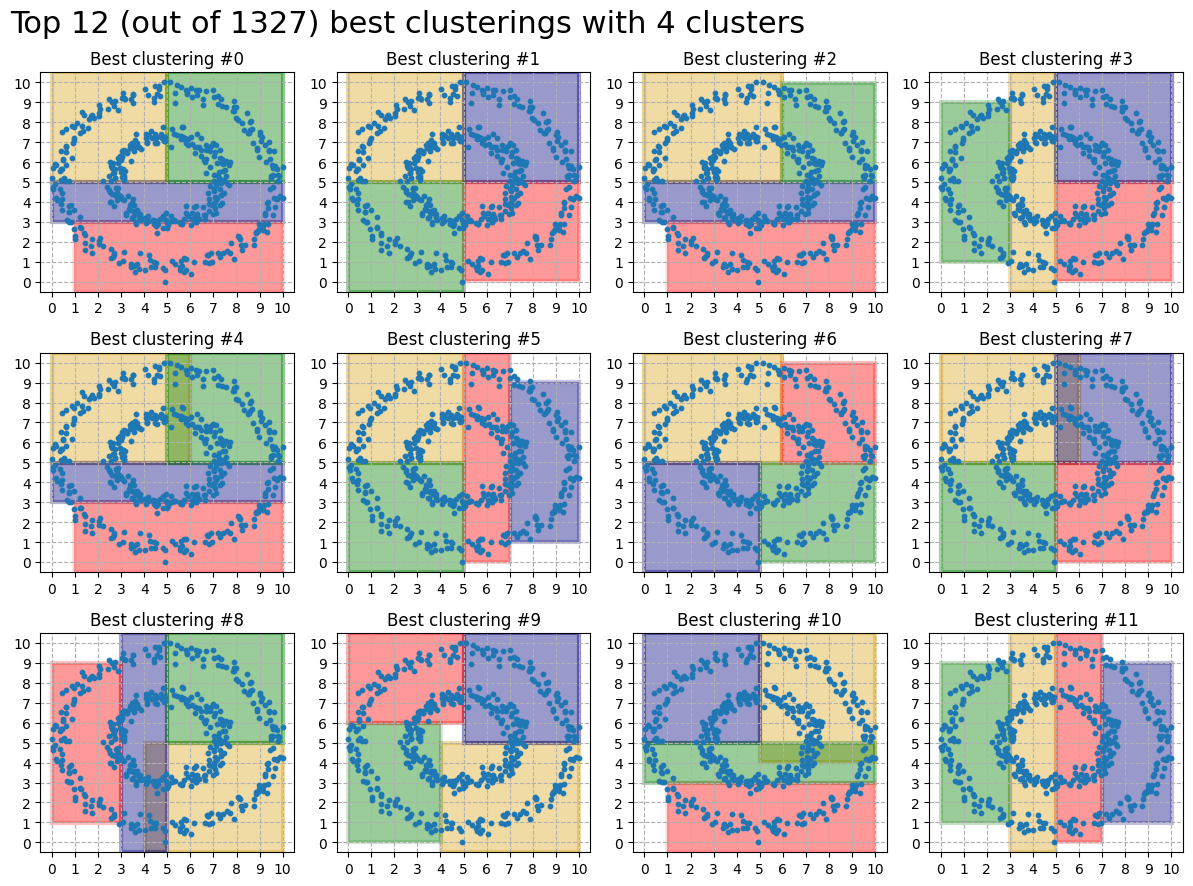

In [45]:
fig, axs = plt.subplots(3, 4, figsize=(12, 9))

for i, (ax, best_clustering) in enumerate(zip(axs.flatten(), clusterings4_df.index)):
    vlib.init_axis(ax, f"Best clustering #{i}", 
                   linscale_x, linscale_y, range(len(linscale_x)), range(len(linscale_y)), 
                   grid_params=dict(zorder=0, linestyle='--'))
    
    ax.scatter(X[:,0], X[:,1], zorder=2, s=10)
    vlib.draw_clustering(ax, best_clustering, concepts_df)

fig.suptitle(f'Top {len(axs.flatten())} (out of {len(clusterings4_df)}) best clusterings with 4 clusters',
             size=22, ha='left', x=0.01)
fig.tight_layout()
fig.subplots_adjust()
# ax.legend(loc='lower right')
fig.savefig('../figures/best_clusters4_circlesdata.pdf')
plt.show()